In [1]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2
import swifter

# Dataset functions

In [2]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [3]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
def visualize_multiple_rows(*image_lists, names = None):
    n = len(image_lists)
    m = len(image_lists[0])

    fig, axes = plt.subplots(m, n, figsize=(12, 60))
    
    for i, image_list in enumerate(image_lists):
        for j, image in enumerate(image_list):
            axes[j, i].imshow(image)
            axes[j, i].axis("off")
    plt.show()

In [5]:
def visualize_random_rows(show_num, *image_lists, names = None):
    n = len(image_lists)
    m = show_num

    fig, axes = plt.subplots(m, n, figsize=(12, 60))

    for i, a in enumerate(np.random.randint(len(image_lists[0]), size=(m))):
        for j, image_list in enumerate(image_lists):
            axes[i, j].imshow(image_list[a])
            axes[i, j].axis("off")
            
    plt.show()

In [6]:
masks_df = pd.read_csv('datasets/airbus-ship-detection/train_ship_segmentations_v2.csv')

For this notebook to work properly unzip the dataset under **datasets** directory

# Creating model with tensorflow

## Working with dataset

In [7]:
masks_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Masks are encoded, images are saved separately

In [8]:
side_size = 128 # size of input and output layers of model

### Loading and decoding data into a numpy array

In [9]:
import cv2

def resize_mask(row):  # decodes and resizes masks to side_size by side_size
    
    if row["EncodedPixels"] is np.NaN:
        return np.zeros((side_size, side_size))
    
    mask = row["EncodedPixels"]
    
    np_seg = rle_decode(mask)

    return cv2.resize(np_seg, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

In [10]:
train_dir = "datasets/airbus-ship-detection/train_v2"
x_train_dir = f"{train_dir}"


def load_resize_image(row): # loads images into the dataframe
    image = cv2.imread(os.path.join(x_train_dir, row["ImageId"]))
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

    return image

It was decided to limit the amount of data model trains on to minimize time, due to hardware constrains

In [11]:
masks_df_slice = pd.concat([masks_df.dropna(), masks_df[masks_df.isna().any(axis=1)][:10000]])
masks_df_slice

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
15534,1105c6f28.jpg,NaN
15535,1105d1c53.jpg,NaN
15536,1105ffd59.jpg,NaN
15538,11067b923.jpg,NaN


In [12]:
masks_df_slice["decoded_mask"] = masks_df_slice.swifter.apply(resize_mask, axis = 1)
masks_df_slice

Pandas Apply:   0%|          | 0/91723 [00:00<?, ?it/s]

,ImageId,EncodedPixels,decoded_mask
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
15534,1105c6f28.jpg,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
15535,1105d1c53.jpg,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
15536,1105ffd59.jpg,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
15538,11067b923.jpg,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [13]:
grouped = masks_df_slice.drop("EncodedPixels", axis = 1).groupby("ImageId").sum().reset_index()
grouped

,ImageId,decoded_mask
0,00003e153.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0001124c7.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0001b1832.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...
52551,fff77c602.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
52552,fff909871.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
52553,fffcb6464.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
52554,fffd924fb.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [14]:
grouped["Area"] = grouped["decoded_mask"].apply(lambda x: x.sum())
grouped_slice = grouped[(grouped["Area"] > 6) | (grouped["Area"] == 0)]
len(grouped_slice)

41477

In [15]:
grouped_slice["gr_image"] = grouped_slice.swifter.apply(load_resize_image, axis = 1)

Pandas Apply:   0%|          | 0/41477 [00:00<?, ?it/s]

C:\Users\misha\AppData\Local\Temp\ipykernel_9500\1594089281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_slice["gr_image"] = grouped_slice.swifter.apply(load_resize_image, axis = 1)


Resulting 41477 photos that will be used in training

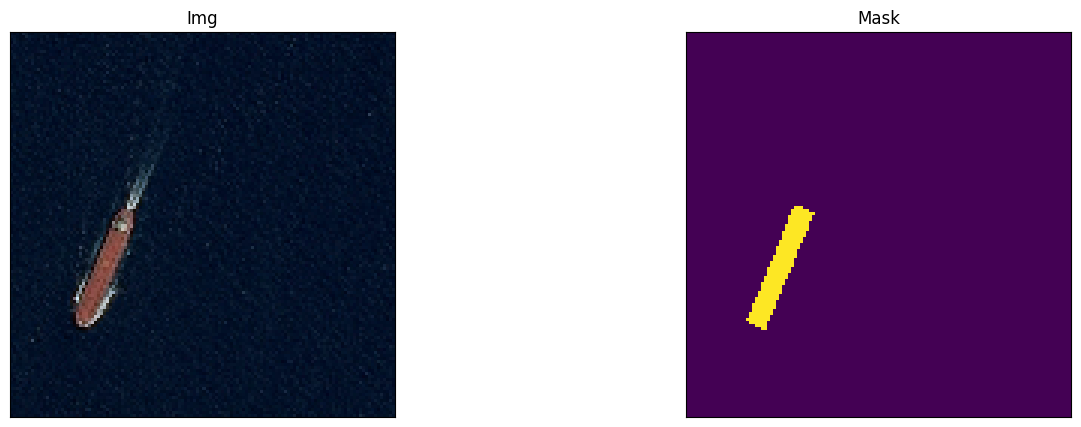

In [16]:
visualize(img = grouped_slice.loc[745, "gr_image"], mask = grouped_slice.loc[745, "decoded_mask"])  # demonstraiting a sample from dataset

In [17]:
xy_train = grouped_slice[["gr_image", "decoded_mask"]].sample(frac=0.8,random_state=200) # split dataset into train and test sets, split is 80/20
xy_test = grouped_slice[["gr_image", "decoded_mask"]].drop(xy_train.index) # remove train part from test partition

x_train = xy_train.drop("decoded_mask", axis = 1)
x_test = xy_test.drop("decoded_mask", axis = 1)

y_train = xy_train[["decoded_mask"]]
y_test = xy_test[["decoded_mask"]]

In [18]:
y_train_numpy = np.stack(y_train[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_train_numpy = y_train_numpy.reshape(*y_train_numpy.shape, 1) # transform it into 4d array for model compatability
y_train_numpy[y_train_numpy > 1] = 1 # due to the procces of merging all of the masks, some overlap, creating values above 1
y_train_numpy.shape

(33182, 128, 128, 1)

In [19]:
x_train_numpy = np.stack(x_train[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 4d numpy array
x_train_numpy.shape

(33182, 128, 128, 3)

In [20]:
y_test_numpy = np.stack(y_test[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_test_numpy = y_test_numpy.reshape(*y_test_numpy.shape, 1) # transform it into 4d array for model compatability
y_test_numpy[y_test_numpy > 1] = 1 # due to the procces of merging all of the masks, some overlap, creating values above 1
y_test_numpy.shape

(8295, 128, 128, 1)

In [21]:
x_test_numpy = np.stack(x_test[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 4d numpy array
x_test_numpy.shape

(8295, 128, 128, 3)

## Augmenting the training data

In [22]:
import imgaug as ia
import imgaug.augmenters as iaa

In [23]:
aug_seq = iaa.Sequential([
    iaa.imgcorruptlike.Fog(severity=(1,3))
], random_order=False)

In [24]:
x_train_numpy_aug = aug_seq(images = x_train_numpy) # adding fog to images to imitate clouds

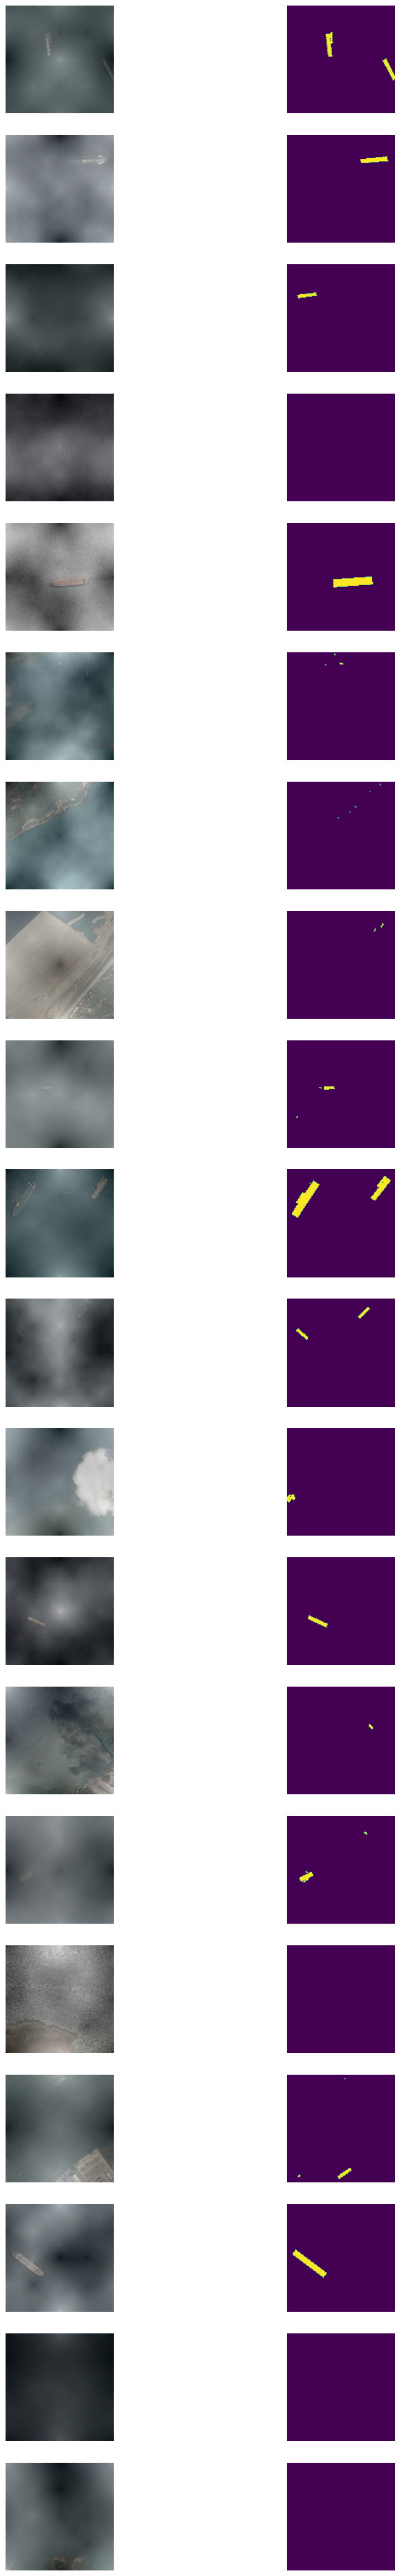

In [25]:
slice_num = 2000
slice_amount = 20

visualize_multiple_rows(
    x_train_numpy_aug[slice_num : slice_num + slice_amount],
    y_train_numpy[slice_num : slice_num + slice_amount]
)

In [26]:
# fliping images vertically and horisontaly

x_train_numpy_vr = x_train_numpy[:, :, ::-1, :]
y_train_numpy_vr = y_train_numpy[:, :, ::-1, :]
x_train_numpy_hr = x_train_numpy[:, ::-1, :, :]
y_train_numpy_hr = y_train_numpy[:, ::-1, :, :]
x_train_numpy_hr_vr = x_train_numpy[:, ::-1, ::-1, :]
y_train_numpy_hr_vr = y_train_numpy[:, ::-1, ::-1, :]

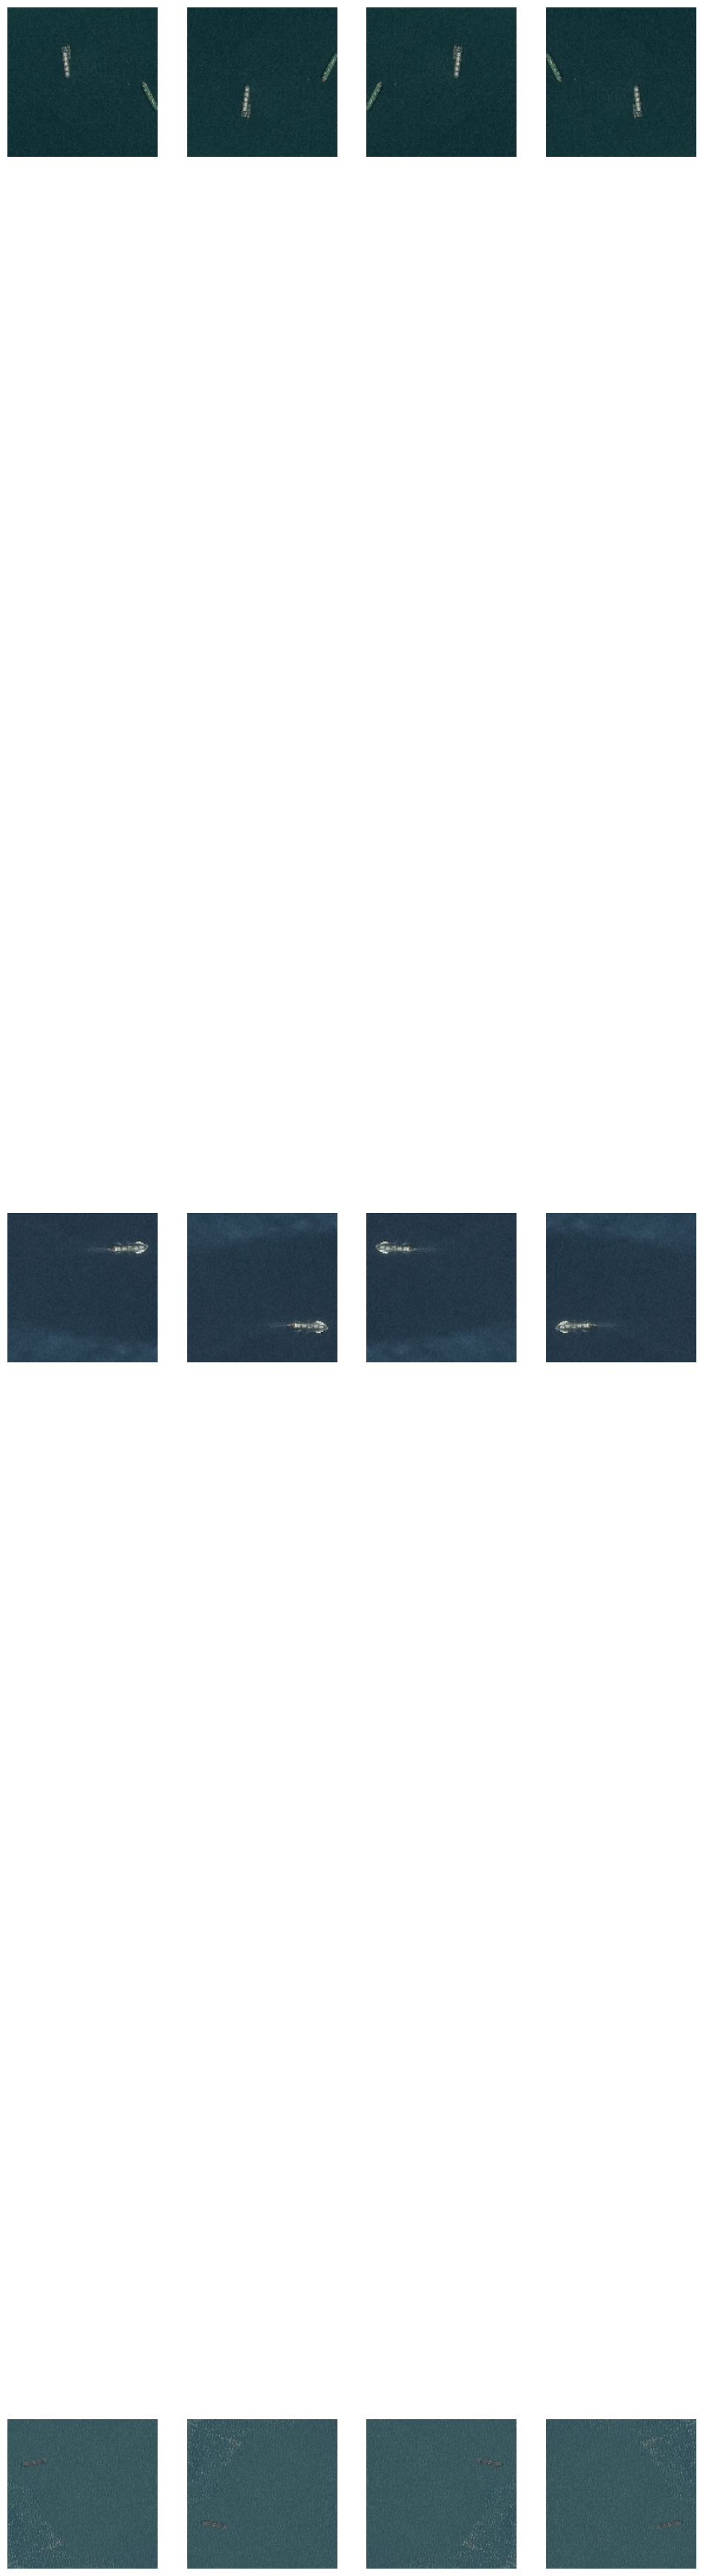

In [27]:
slice_num = 2000
slice_amount = 3

visualize_multiple_rows(
    x_train_numpy[slice_num : slice_num + slice_amount],
    x_train_numpy_hr[slice_num : slice_num + slice_amount],
    x_train_numpy_vr[slice_num : slice_num + slice_amount],
    x_train_numpy_hr_vr[slice_num : slice_num + slice_amount],
)

In [28]:
# slicing the datasets
# the split is:
# 100% of original images                  ~ 50% of resulting training set
# 33% of augmented                         ~ 15% of resulting training set
# 25% of verticaly flipped                 ~ 12% of resulting training set
# 25% of horisontaly flipped               ~ 12% of resulting training set
# 25% of verticaly and horisontaly flipped ~ 12% of resulting training set

x_train_numpy_final = np.concatenate((
    x_train_numpy, 
    x_train_numpy_aug[2::3], 
    x_train_numpy_vr[2::4], 
    x_train_numpy_hr[3::4], 
    x_train_numpy_hr_vr[3::4]
))
y_train_numpy_final = np.concatenate((
    y_train_numpy, 
    y_train_numpy[2::3], 
    y_train_numpy_vr[2::4],
    y_train_numpy_hr[3::4], 
    y_train_numpy_hr_vr[3::4]
))

In [29]:
np.save("fitting_data/x_train_numpy_final", x_train_numpy_final)
np.save("fitting_data/y_train_numpy_final", y_train_numpy_final)
np.save("fitting_data/x_test_numpy", x_test_numpy)
np.save("fitting_data/y_test_numpy", y_test_numpy)

## Train the model

In [30]:
import tensorflow as tf
import keras

In [31]:
# Defining the U-net model
segmentation_model = keras.models.Sequential([

    # input and rescaling
    keras.layers.Input(shape=(side_size, side_size, 3)),
    keras.layers.Rescaling(1. / 255),

    # convolution layers
    keras.layers.Conv2D(64, 3, padding="same", activation="relu", strides=2),
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, 3, padding="same", activation="relu", strides=2),
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.Dropout(0.01),

    # transpose layers
    keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu", strides=2),
    keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu", strides=2),
    keras.layers.Dropout(0.01),

    # output layer
    keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid")
])

segmentation_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,625 (2.54 MB)

 Trainable params: 666,625 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
x_train_numpy_final = np.load("fitting_data/x_train_numpy_final.npy")
y_train_numpy_final = np.load("fitting_data/y_train_numpy_final.npy")

x_test_numpy = np.load("fitting_data/x_test_numpy.npy")
y_test_numpy = np.load("fitting_data/y_test_numpy.npy")

In [33]:
# compile the model
segmentation_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[keras.metrics.BinaryIoU(), keras.metrics.BinaryAccuracy()])

In [34]:
callbacks = [keras.callbacks.ModelCheckpoint("models/best_model.keras", save_best_only=True)]

In [35]:
history = segmentation_model.fit(x_train_numpy_final, y_train_numpy_final, epochs=3, batch_size=128, validation_data=(x_test_numpy, y_test_numpy), callbacks=callbacks)

Epoch 1/3
541/541 ━━━━━━━━━━━━━━━━━━━━ 2466s 5s/step - binary_accuracy: 0.9946 - binary_io_u: 0.4974 - loss: 0.0626 - val_binary_accuracy: 0.9950 - val_binary_io_u: 0.5087 - val_loss: 0.0147
Epoch 2/3
541/541 ━━━━━━━━━━━━━━━━━━━━ 2828s 5s/step - binary_accuracy: 0.9954 - binary_io_u: 0.5671 - loss: 0.0152 - val_binary_accuracy: 0.9962 - val_binary_io_u: 0.6731 - val_loss: 0.0124
Epoch 3/3
541/541 ━━━━━━━━━━━━━━━━━━━━ 2998s 6s/step - binary_accuracy: 0.9960 - binary_io_u: 0.6598 - loss: 0.0130 - val_binary_accuracy: 0.9965 - val_binary_io_u: 0.6883 - val_loss: 0.0110


In [36]:
segmentation_model.save("models/segmentation_model.keras")

# Testing the model

In [37]:
res = segmentation_model.evaluate(x_test_numpy, y_test_numpy)

260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 264ms/step - binary_accuracy: 0.9979 - binary_io_u: 0.6878 - loss: 0.0068


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


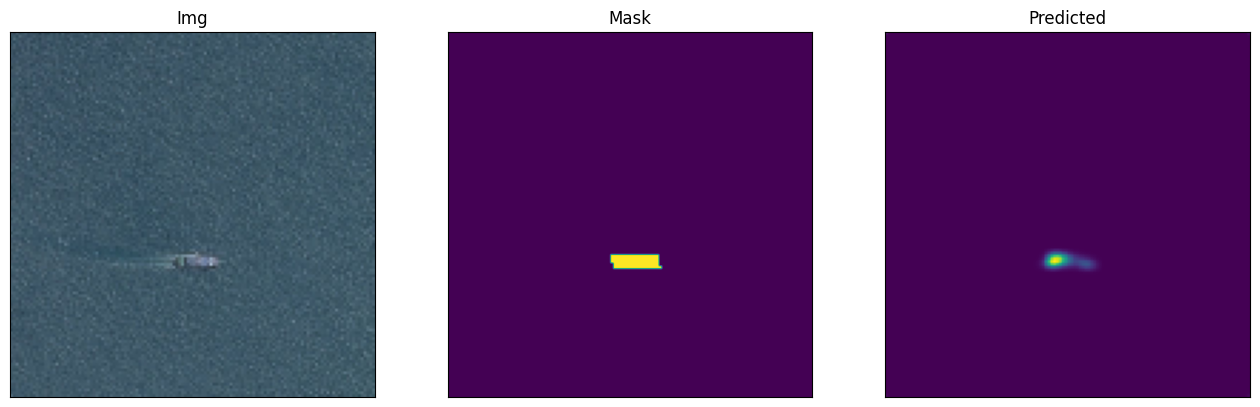

In [38]:
test_image = 0


visualize(img = x_test_numpy[test_image], mask = y_test_numpy[test_image], predicted = segmentation_model.predict(x_test_numpy[test_image].reshape(1, 128, 128, 3))[0])

Resulting model shows great results in ship designation on seas while requiring little to no training and time to run, however Dice score shows possible improvement of the model, that might be done by altering dataset to include more marked ships

In [39]:
x_test_numpy = np.load("x_test_numpy.npy")
y_test_numpy = np.load("y_test_numpy.npy")

In [40]:
best_model = keras.saving.load_model("models/best_model.keras")

In [41]:
best_model.evaluate(x_test_numpy, y_test_numpy)

260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 256ms/step - binary_accuracy: 0.9979 - binary_io_u: 0.6878 - loss: 0.0068


[0.010986427776515484, 0.688283383846283, 0.9964702725410461]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


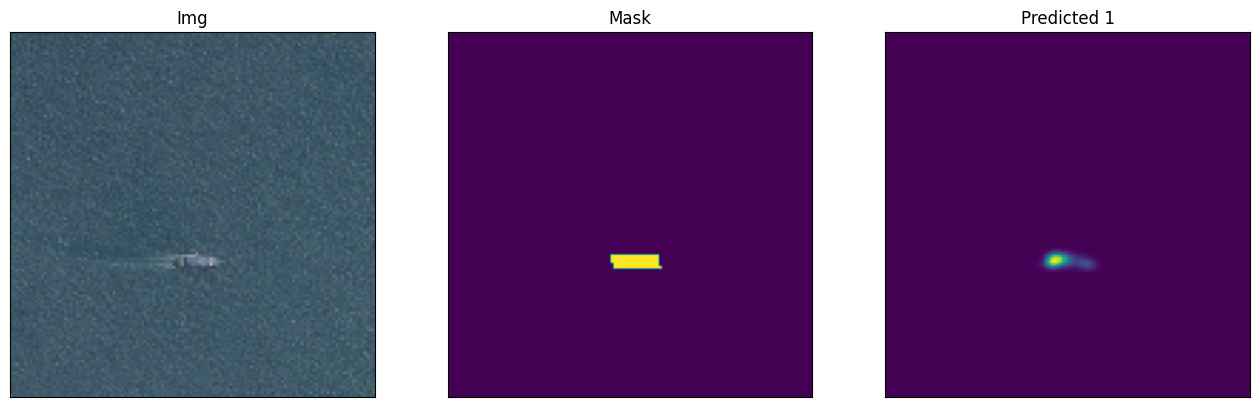

In [42]:
test_image = 0


visualize(img = x_test_numpy[test_image], mask = y_test_numpy[test_image], predicted_1 = best_model.predict(x_test_numpy[test_image].reshape(1, 128, 128, 3))[0])

In [43]:
all_prediction = best_model.predict(x_test_numpy)

260/260 ━━━━━━━━━━━━━━━━━━━━ 63s 242ms/step


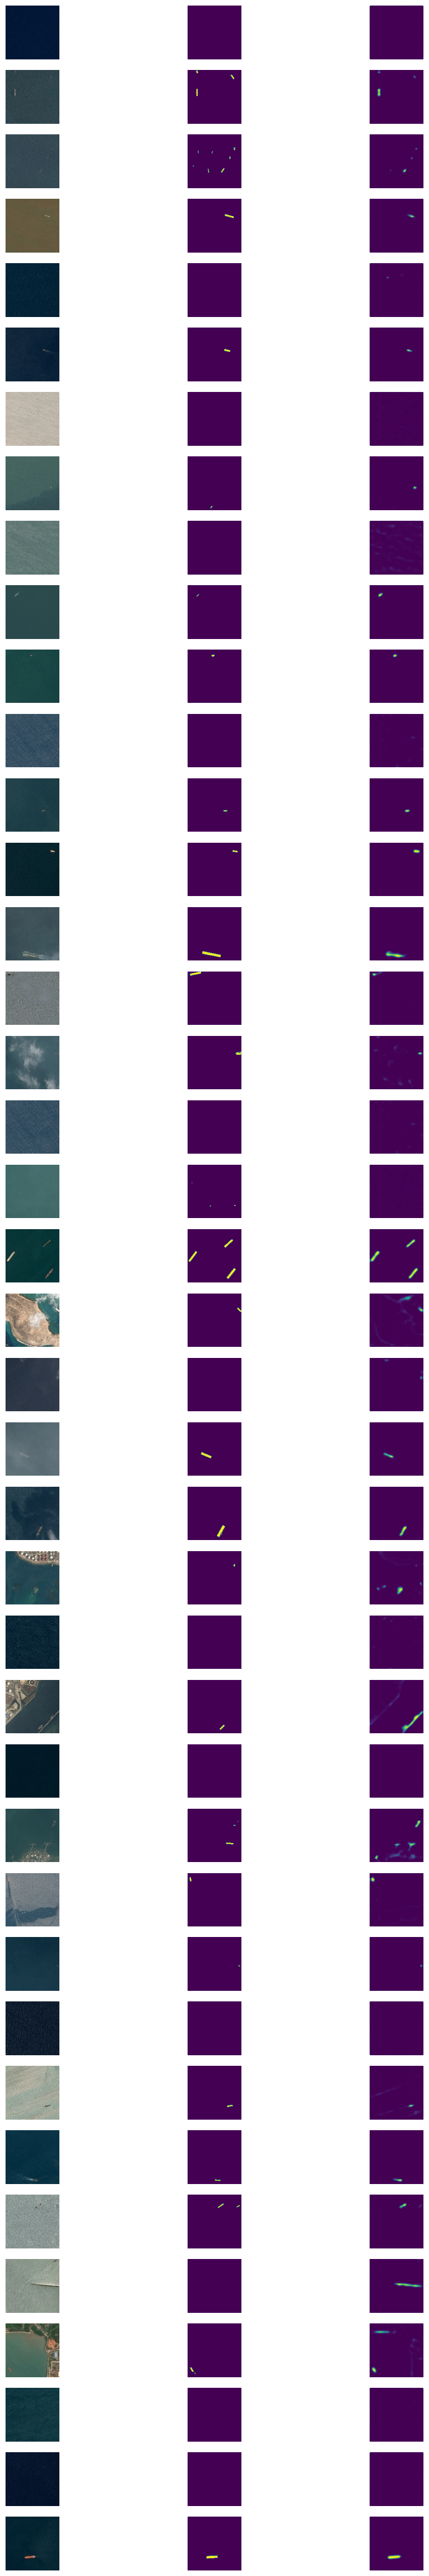

In [44]:
# see overal model results

visualize_random_rows(
    40,
    x_test_numpy,
    y_test_numpy,
    all_prediction
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


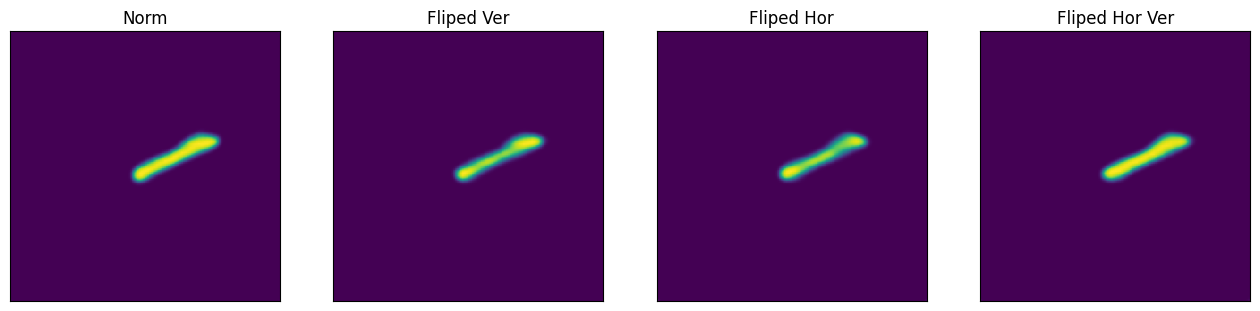

In [45]:
# test to see if horisontal and vertical flipping impacts the prediction

slice_num = 20

visualize(
    norm = best_model.predict(x_test_numpy[slice_num].reshape(1,128,128,3))[0],
    fliped_ver = cv2.flip(best_model.predict(cv2.flip(x_test_numpy[slice_num], 1).reshape(1,128,128,3))[0], 1),
    fliped_hor = cv2.flip(best_model.predict(cv2.flip(x_test_numpy[slice_num], 0).reshape(1,128,128,3))[0], 0),
    fliped_hor_ver = cv2.flip(best_model.predict(cv2.flip(x_test_numpy[slice_num], -1).reshape(1,128,128,3))[0], -1),
)